In [1]:
import json
import pandas as pd
from skimage.io import imread
import cv2
from tqdm import tqdm, tqdm_notebook
import pythreshold
from pythreshold.local_th import wolf, feng, niblack, bernsen
from scipy.spatial.distance import cdist

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Approach summary

Running grabcut algorithm for crop improvement.

## Reading data

In [2]:
DATA_FOLDER = "./tocorrect/"
data = pd.read_csv("./tocorrect/crop_regions.csv")

In [3]:
def str_to_dict(s):
    return json.loads(s.replace("u'", "'").replace("\'", "\""))

In [4]:
data["crop_regions"] = data["crop_regions"].apply(str_to_dict)

In [5]:
data

receipt_id                  file_path  \
0      3487830  receipt_files/3487830.jpg   
1      3490860  receipt_files/3490860.jpg   
2      3491247  receipt_files/3491247.jpg   
3      3487613  receipt_files/3487613.jpg   
4      3488933  receipt_files/3488933.jpg   
5      3488767  receipt_files/3488767.jpg   
6      3490818  receipt_files/3490818.jpg   
7      3488055  receipt_files/3488055.jpg   
8      3489461  receipt_files/3489461.jpg   
9      3489909  receipt_files/3489909.jpg   
10     3490501  receipt_files/3490501.jpg   

                                         crop_regions  
0   [[{'y': 46, 'x': 1032}, {'y': 1212, 'x': 995},...  
1   [[{'y': 288, 'x': 531}, {'y': 285, 'x': 731}, ...  
2   [[{'y': 393, 'x': 546}, {'y': 383, 'x': 669}, ...  
3   [[{'y': 222, 'x': 1927}, {'y': 938, 'x': 1891}...  
4   [[{'y': 155, 'x': 1343}, {'y': 177, 'x': 1667}...  
5   [[{'y': 623, 'x': 795}, {'y': 724, 'x': 866}, ...  
6   [[{'y': 279, 'x': 1238}, {'y': 1701, 'x': 1234...  
7   [[{'y': 91, 'x': 1065}, {'y': 108, 'x': 2704},...  
8   [[{'y': 39, 'x': 395}, {'y': 256, 'x': 392}, {...  
9   [[{'y': 239, 'x': 1529}, {'y': 2048, 'x': 1536...  
10  [[{'y': 405, 'x': 686}, {'y': 363, 'x': 1986},...

## Running pipeline

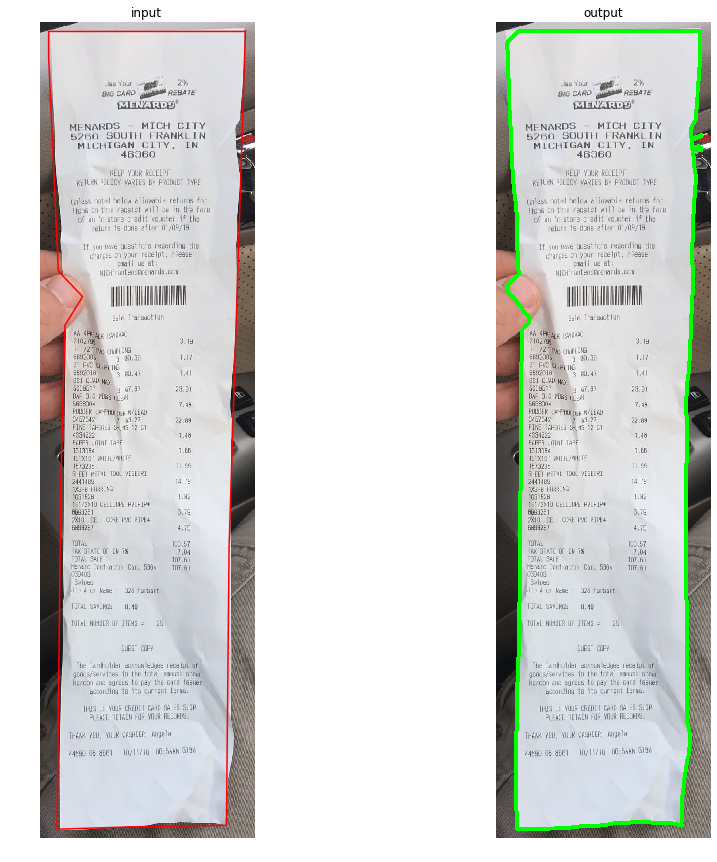

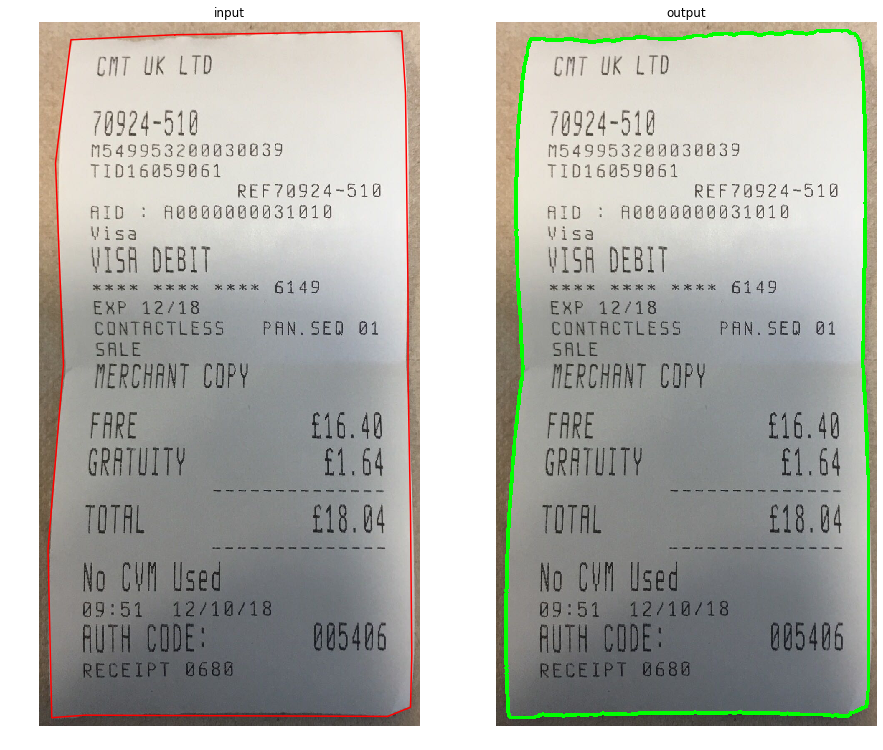

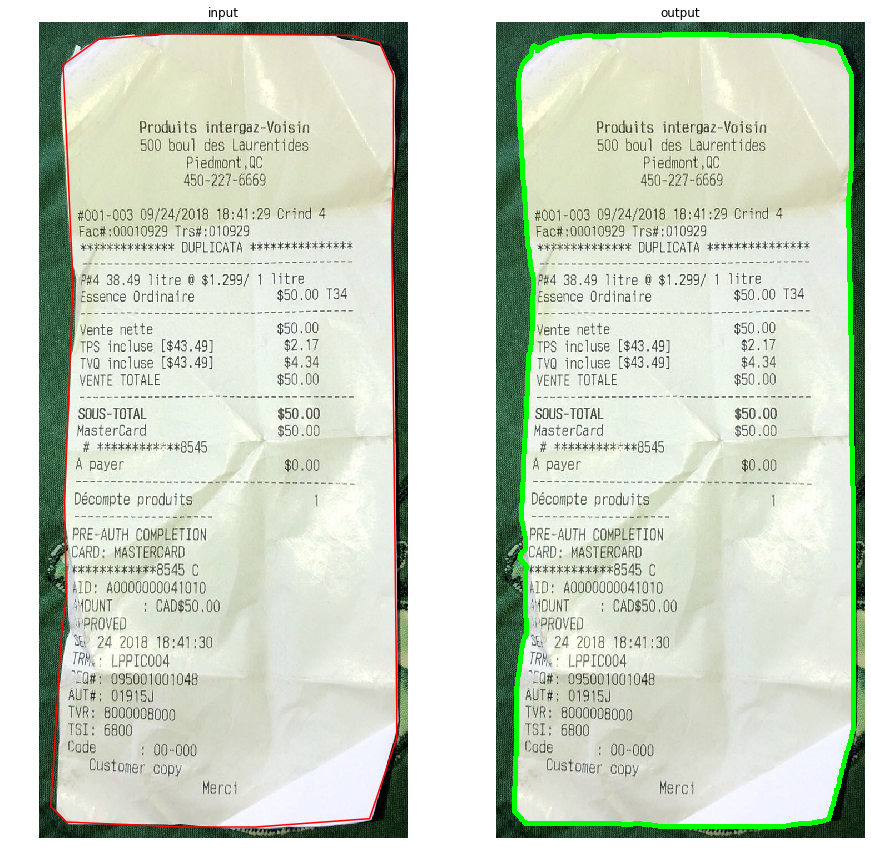

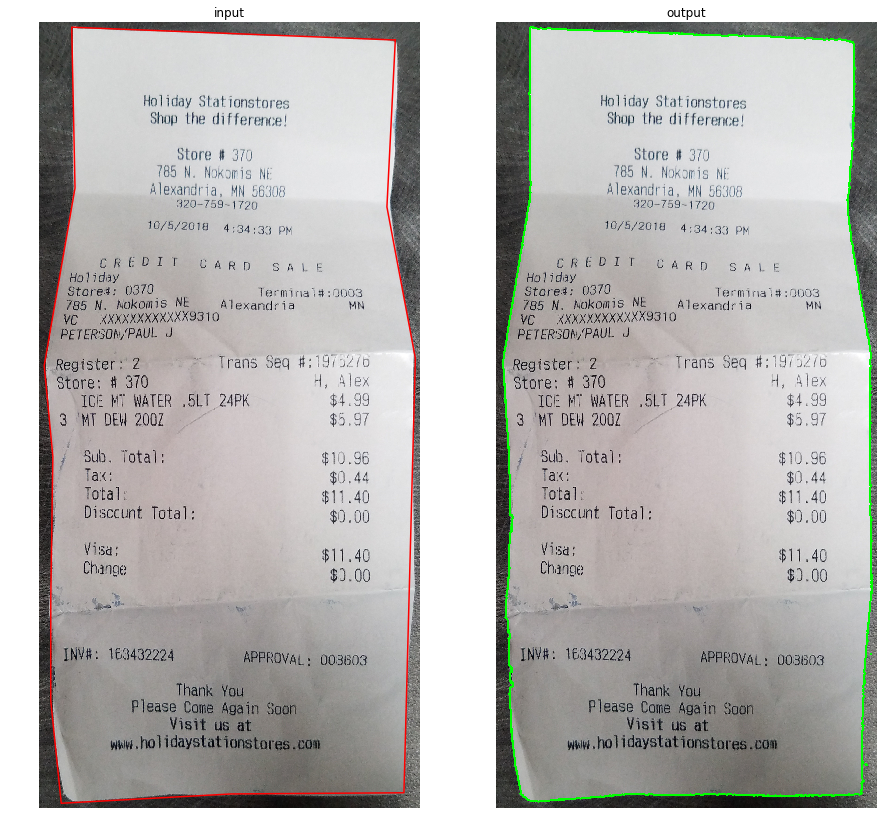

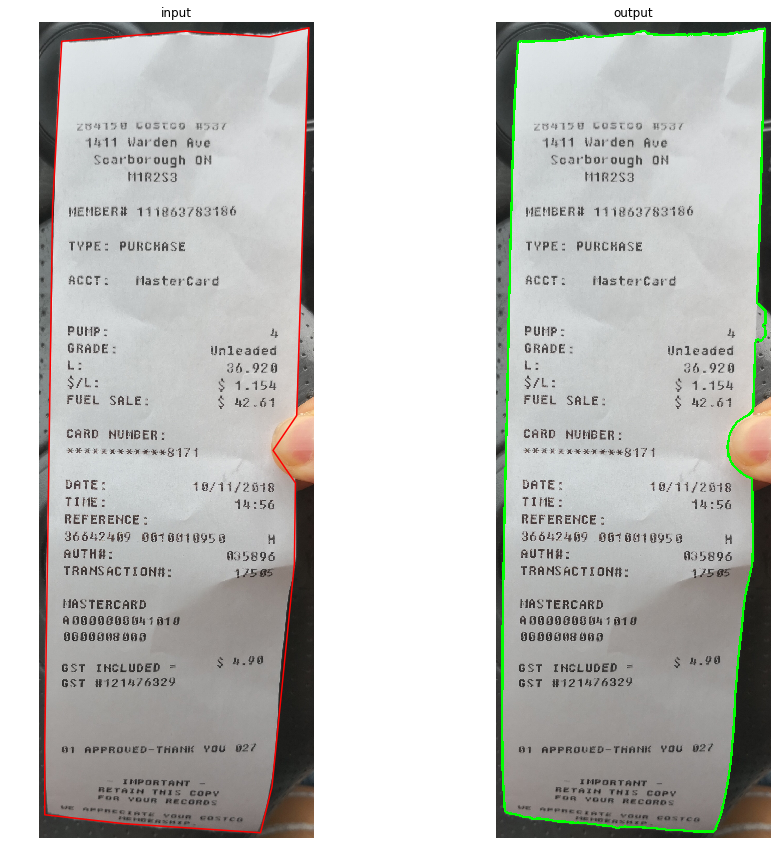

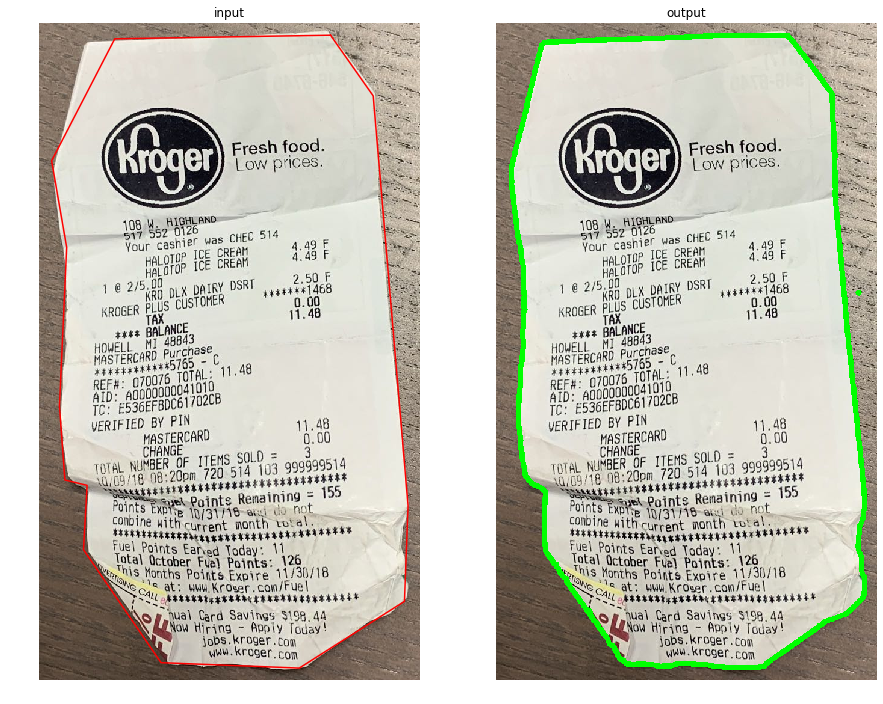

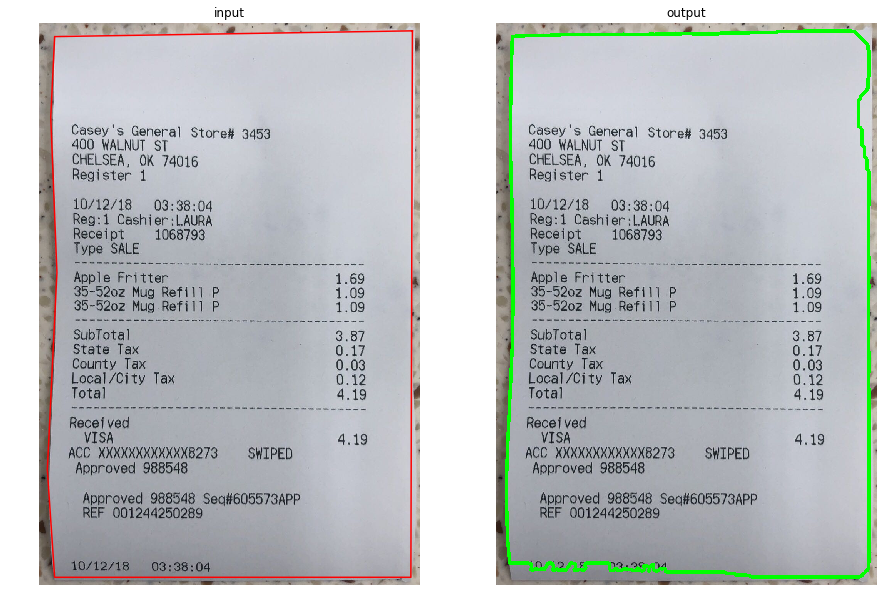

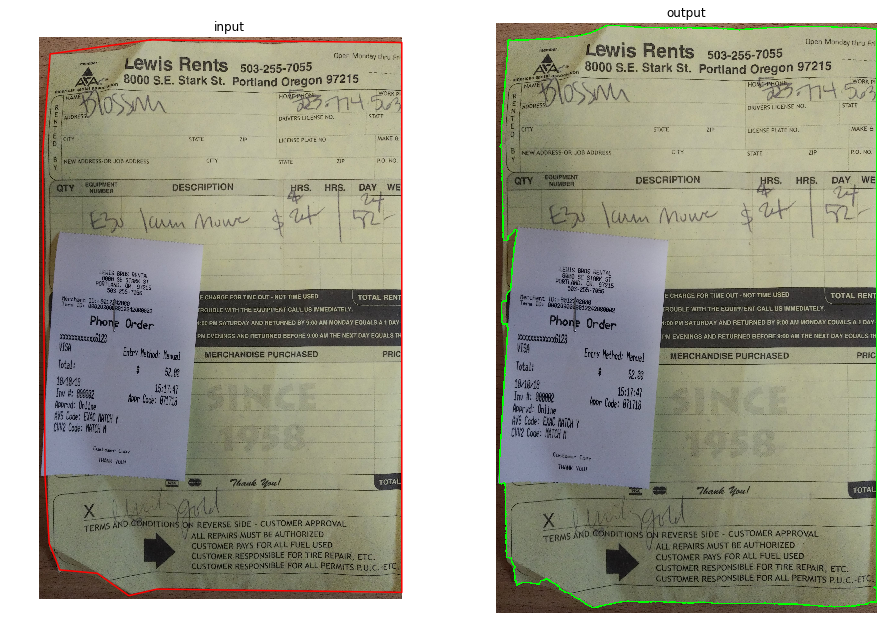

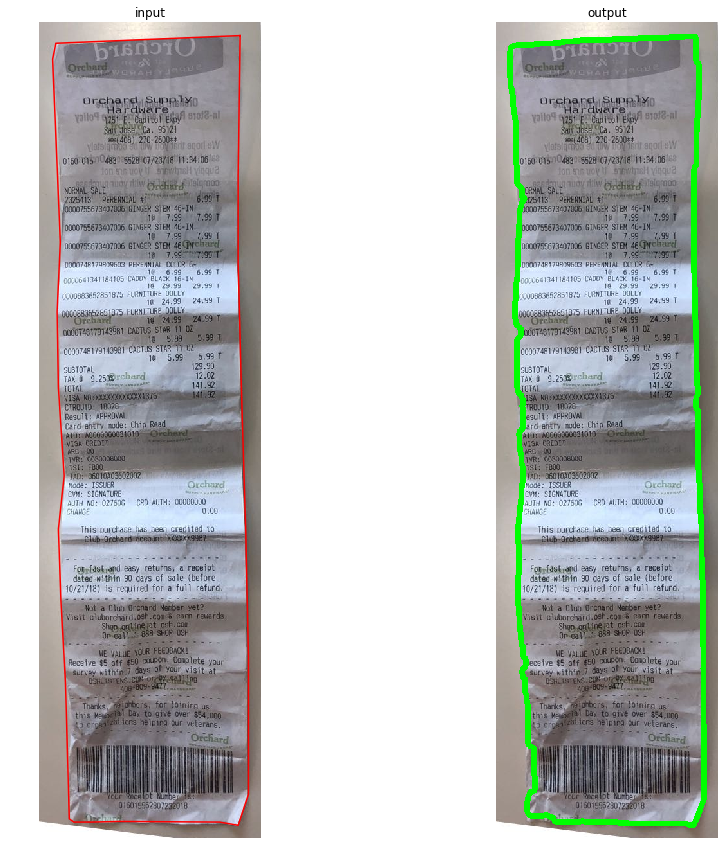

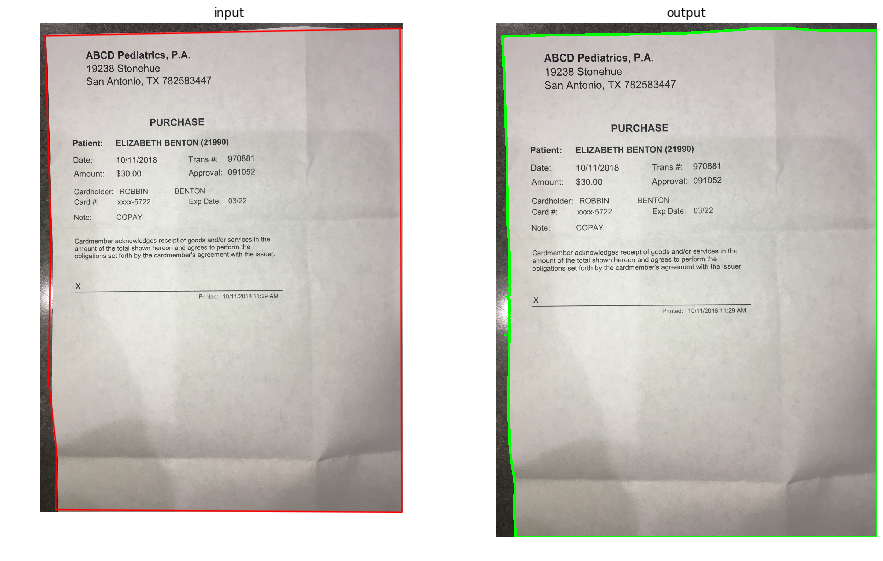

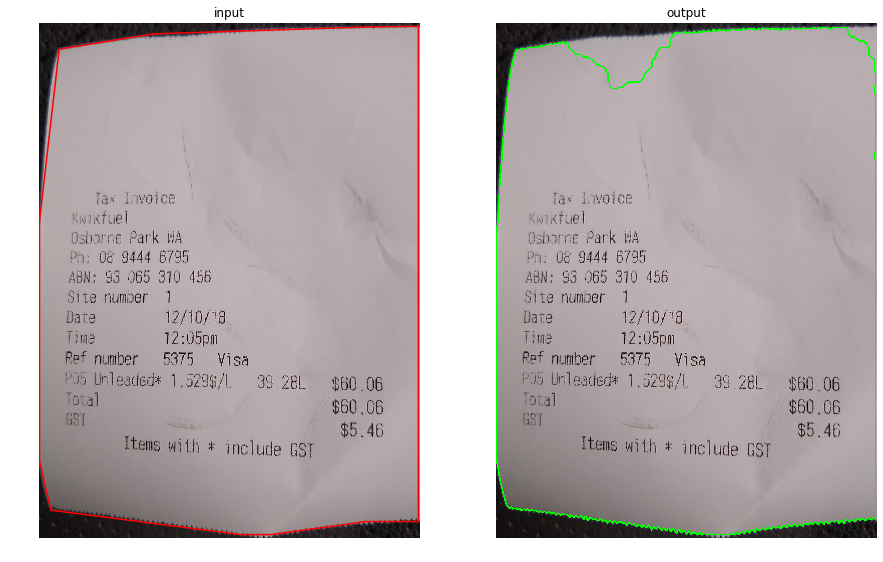

In [12]:
offset = 20
for i, row in data.iterrows():
    img = cv2.imread(DATA_FOLDER + row["file_path"])
    
    line_x = [d["x"] for d in row["crop_regions"][0]]
    line_x.append(line_x[0])
    
    line_y = [d["y"] for d in row["crop_regions"][0]]
    line_y.append(line_y[0])
    
    crop = img[max(min(line_y) - offset, 0) : min(max(line_y) + offset, img.shape[0]), 
               max(min(line_x) - offset, 0) : min(max(line_x) + offset,  img.shape[1])].copy()
    
    crop_line_x = [x - max(min(line_x) - offset, 0) for x in line_x]
    crop_line_y = [y - max(min(line_y) - offset, 0) for y in line_y]
    
    mask = np.zeros(crop.shape[:2], dtype=np.uint8)
    rectanlge = (min(crop_line_x), min(crop_line_y),
                 max(crop_line_x) -  min(crop_line_x), 
                 max(crop_line_y) - min(crop_line_y))
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask, bgdModel, fgdModel = cv2.grabCut(crop, mask, rectanlge, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==0) | (mask==2),0,1).astype('uint8')
    contours, hierarchy = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    out = cv2.drawContours(np.zeros_like(crop), contours, -1, (0, 255, 0), 7)
    mask= np.expand_dims(np.max(out, axis=-1) > 0, -1)
    
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    f, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(crop_rgb, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title("input")
    axs[0].plot(crop_line_x, crop_line_y, color="red")
    
    axs[1].imshow(crop_rgb * (1-mask) + out, cmap="gray")
    axs[1].axis("off")
    axs[1].set_title("output")
    plt.show()